### **Análisis Exploratorio de Datos (EDA) en Databricks**

Este notebook forma parte del trabajo final del curso de MLOps  y se centra en el **Análisis Exploratorio de Datos (EDA)**, una fase esencial en la construcción de un pipeline de Machine Learning.

El objetivo del EDA es comprender la estructura y calidad de los datos antes del modelado. Para ello, se realizan los siguientes análisis:

- **Carga de datos desde Delta Lake** y validación de su estructura.
- **Cálculo de estadísticas descriptivas** para analizar la distribución de las variables.
- **Detección de valores nulos** para evaluar la calidad de los datos.
- **Análisis de la variable objetivo** para examinar el balance de clases.
- **Cálculo de la matriz de correlación** para identificar relaciones entre variables.

Estos análisis permiten tomar decisiones informadas sobre la preparación de los datos y detectar posibles problemas antes del entrenamiento del modelo.

<style>
    p { text-align: justify; }
</style>


### 1. Carga de datos en Apache Spark
Se inicia una sesión de Apache Spark en Databricks y se carga el conjunto de datos desde Delta Lake, donde fue almacenado en la fase de ingesta.

In [0]:
from pyspark.sql import SparkSession

# Iniciar sesión de Spark
spark = SparkSession.builder.appName("EDA_Mining_Data").getOrCreate()

# Definir la ruta donde guardamos los datos en Delta Lake
delta_path = "dbfs:/mnt/delta/mining_data"

# Cargar la data en un DataFrame de Spark
df_spark = spark.read.format("delta").load(delta_path)

# Mostrar esquema y primeras filas
df_spark.printSchema()
df_spark.show(5)


root
 |-- Accident_Occurred: integer (nullable = true)
 |-- Hours_Worked: integer (nullable = true)
 |-- Weather_Risk_Index: double (nullable = true)
 |-- Machine_Age_Years: integer (nullable = true)
 |-- Employee_Experience_Years: integer (nullable = true)
 |-- Safety_Violations: integer (nullable = true)
 |-- Inspection_Frequency: integer (nullable = true)
 |-- Job_Risk_Level: integer (nullable = true)
 |-- Shift_Type: integer (nullable = true)
 |-- Area: integer (nullable = true)
 |-- Employee_Age: integer (nullable = true)
 |-- Noise_Level_dB: double (nullable = true)
 |-- Temperature_C: double (nullable = true)

+-----------------+------------+------------------+-----------------+-------------------------+-----------------+--------------------+--------------+----------+----+------------+-----------------+------------------+
|Accident_Occurred|Hours_Worked|Weather_Risk_Index|Machine_Age_Years|Employee_Experience_Years|Safety_Violations|Inspection_Frequency|Job_Risk_Level|Shift_Type

### 2. Resumen estadístico de los datos
Se generan estadísticas descriptivas de las variables numéricas del dataset, lo que permite entender su distribución general y detectar posibles valores atípicos.

In [0]:
# Resumen estadístico de todas las columnas numéricas
df_spark.describe().show()


+-------+------------------+-----------------+--------------------+-----------------+-------------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary| Accident_Occurred|     Hours_Worked|  Weather_Risk_Index|Machine_Age_Years|Employee_Experience_Years| Safety_Violations|Inspection_Frequency|    Job_Risk_Level|        Shift_Type|              Area|      Employee_Age|    Noise_Level_dB|     Temperature_C|
+-------+------------------+-----------------+--------------------+-----------------+-------------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|             10000|            10000|               10000|            10000|                    10000|             10000|               10000|             10000|             10000|             

###  3. Detección de valores nulos
Se analiza la cantidad de valores nulos en cada columna para evaluar la calidad de los datos y definir estrategias de imputación si es necesario.

In [0]:
from pyspark.sql.functions import col, sum

# Contar valores nulos en cada columna
df_spark.select([sum(col(c).isNull().cast("int")).alias(c) for c in df_spark.columns]).show()


+-----------------+------------+------------------+-----------------+-------------------------+-----------------+--------------------+--------------+----------+----+------------+--------------+-------------+
|Accident_Occurred|Hours_Worked|Weather_Risk_Index|Machine_Age_Years|Employee_Experience_Years|Safety_Violations|Inspection_Frequency|Job_Risk_Level|Shift_Type|Area|Employee_Age|Noise_Level_dB|Temperature_C|
+-----------------+------------+------------------+-----------------+-------------------------+-----------------+--------------------+--------------+----------+----+------------+--------------+-------------+
|                0|           0|                 0|                0|                        0|                0|                   0|             0|         0|   0|           0|             0|            0|
+-----------------+------------+------------------+-----------------+-------------------------+-----------------+--------------------+--------------+----------+----+---

### 4. Análisis de la variable objetivo
Se realiza un conteo de registros por categoría en la variable "Accident_Occurred" para analizar el balance de clases en el dataset.

In [0]:
df_spark.groupBy("Accident_Occurred").count().show()


+-----------------+-----+
|Accident_Occurred|count|
+-----------------+-----+
|                1| 5091|
|                0| 4909|
+-----------------+-----+



###  5. Matriz de correlación
Se calcula la matriz de correlación entre las variables numéricas del dataset. Esto ayuda a identificar relaciones entre variables que pueden ser útiles en el modelo de Machine Learning.

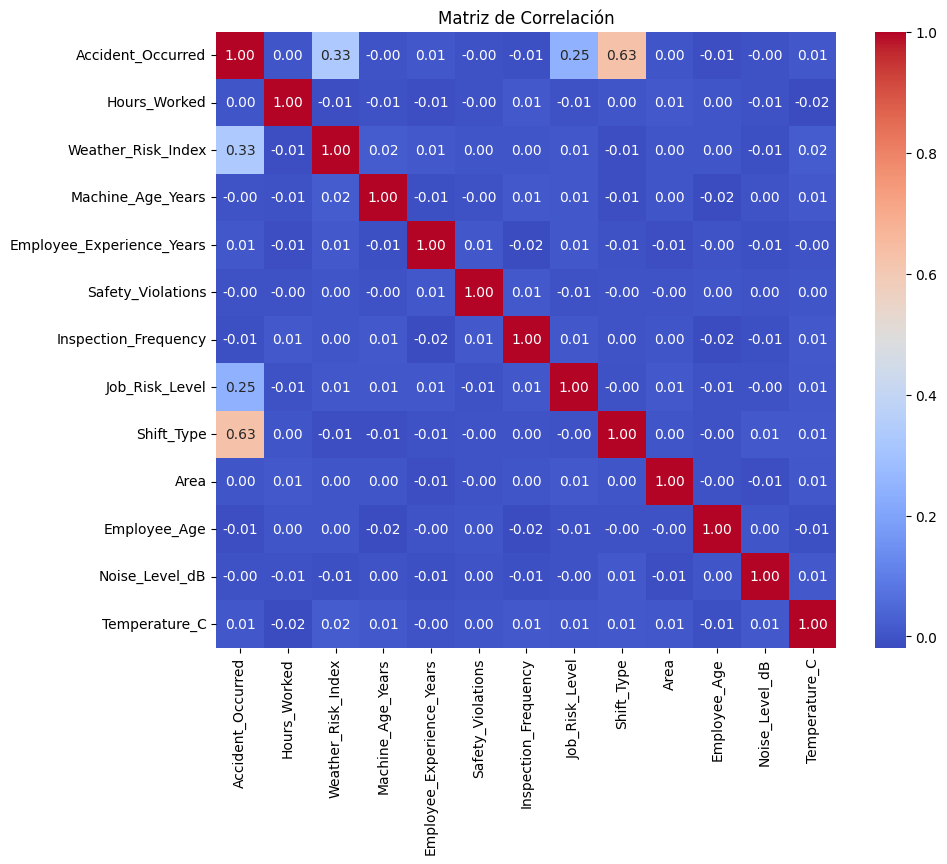

In [0]:
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convertir solo las columnas numéricas a un vector para calcular la correlación
from pyspark.ml.feature import VectorAssembler

numeric_cols = [c for c, t in df_spark.dtypes if t in ("int", "double")]
vector_col = "features"

assembler = VectorAssembler(inputCols=numeric_cols, outputCol=vector_col)
df_vector = assembler.transform(df_spark).select(vector_col)

# Calcular la matriz de correlación
corr_matrix = Correlation.corr(df_vector, vector_col).head()[0].toArray()

# Convertir la matriz a un DataFrame de Pandas para visualización
corr_df = pd.DataFrame(corr_matrix, index=numeric_cols, columns=numeric_cols)

# Graficar el mapa de calor de correlación
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()


La variable "Shift_Type" tiene la correlación más alta con "Accident_Occurred" (0.63).

Esto indica que el tipo de turno podría ser un factor importante en la ocurrencia de accidentes.

"Job_Risk_Level" también muestra una correlación moderada (0.25) con los accidentes.
Esto sugiere que el nivel de riesgo del trabajo es relevante.

"Weather_Risk_Index" tiene una correlación de 0.33, lo que indica que las condiciones climáticas podrían influir en los accidentes.

Otras variables como "Machine_Age_Years", "Employee_Experience_Years" o "Noise_Level_dB" tienen correlaciones muy bajas, lo que sugiere que no tienen una relación fuerte con la ocurrencia de accidentes.


### Selección de Características (Feature Selection)
Para garantizar que el modelo sea eficiente y explicativo, eliminaremos características con baja relevancia y nos quedaremos con las más influyentes.

/root/.ipykernel/7598/command-6853339554501513-2726640640:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")


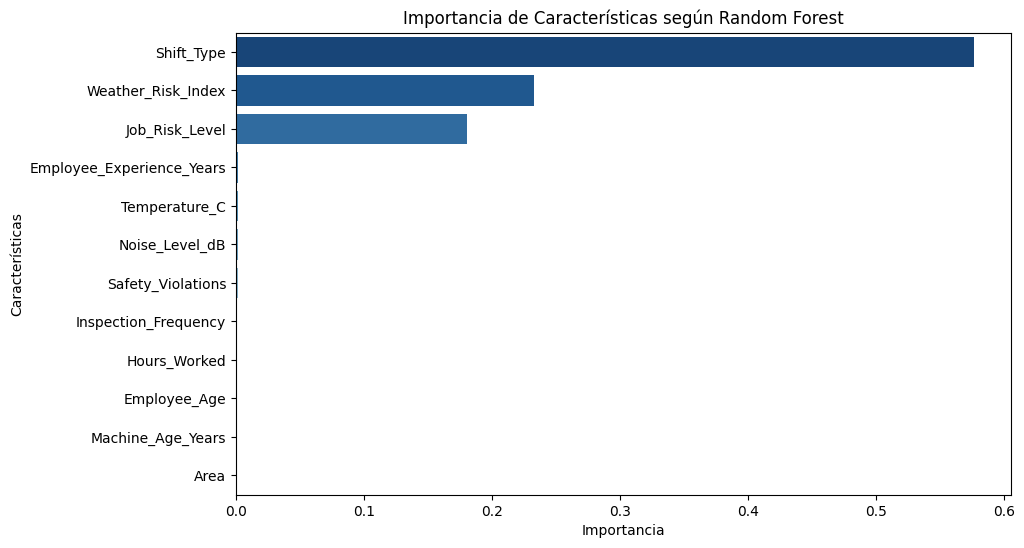

In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.stat import Correlation
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Seleccionar columnas numéricas para el modelo
feature_columns = [c for c in df_spark.columns if c != "Accident_Occurred"]

# Vectorizar las características
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
df_vectorized = assembler.transform(df_spark).select("features", "Accident_Occurred")

# Modelo de Random Forest para medir importancia de características
rf = RandomForestRegressor(featuresCol="features", labelCol="Accident_Occurred", numTrees=10)
model = rf.fit(df_vectorized)

# Obtener importancia de características
importance = model.featureImportances.toArray()

# Convertir a DataFrame para visualizar
importance_df = pd.DataFrame(list(zip(feature_columns, importance)), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Graficar Importancia de Características
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="Blues_r")
plt.title("Importancia de Características según Random Forest")
plt.xlabel("Importancia")
plt.ylabel("Características")
plt.show()


"Shift_Type" (Tipo de Turno) es la variable más relevante. Esto refuerza el hallazgo anterior de la matriz de correlación.
"Weather_Risk_Index" (Riesgo Climático) también tiene alta importancia. Sugiere que condiciones meteorológicas extremas pueden aumentar el riesgo de accidentes.
"Job_Risk_Level" (Nivel de Riesgo del Trabajo) es la tercera variable más influyente.



In [0]:
df_spark.groupBy("Shift_Type").agg(
    {"Accident_Occurred": "sum", "*": "count"}
).withColumnRenamed("sum(Accident_Occurred)", "Total_Accidents")\
 .withColumnRenamed("count(1)", "Total_Cases")\
 .withColumn("Accident_Rate", (col("Total_Accidents") / col("Total_Cases")) * 100)\
 .orderBy("Accident_Rate", ascending=False)\
 .show()


+----------+---------------+-----------+------------------+
|Shift_Type|Total_Accidents|Total_Cases|     Accident_Rate|
+----------+---------------+-----------+------------------+
|         1|           2911|       2911|             100.0|
|         0|           2180|       7089|30.751869092960927|
+----------+---------------+-----------+------------------+



In [0]:
df_spark.filter(col("Shift_Type") == 1).describe().show()


+-------+-----------------+------------------+--------------------+-----------------+-------------------------+------------------+--------------------+------------------+----------+------------------+------------------+-----------------+------------------+
|summary|Accident_Occurred|      Hours_Worked|  Weather_Risk_Index|Machine_Age_Years|Employee_Experience_Years| Safety_Violations|Inspection_Frequency|    Job_Risk_Level|Shift_Type|              Area|      Employee_Age|   Noise_Level_dB|     Temperature_C|
+-------+-----------------+------------------+--------------------+-----------------+-------------------------+------------------+--------------------+------------------+----------+------------------+------------------+-----------------+------------------+
|  count|             2911|              2911|                2911|             2911|                     2911|              2911|                2911|              2911|      2911|              2911|              2911|          

In [0]:
df_spark = df_spark.filter(col("Shift_Type") != 1)


In [0]:
df_spark.groupBy("Shift_Type").count().show()

+----------+-----+
|Shift_Type|count|
+----------+-----+
|         0| 7089|
+----------+-----+

